# PyTorch: IBA (Per-Sample Bottleneck)

This notebook experiments how the position of the Per-Sample Bottleneck affects the result.


In [3]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
    
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

env: CUDA_VISIBLE_DEVICES=0


In [4]:
imagenet_dir = '/home/yang/MLMI_InfoBottleneck/imagenet'

dev = torch.device('cpu:0')

# Define function to perform experiment

The test function takes model and information bottleneck as parameter. Then plot the heapmap at each position respectly.

In [3]:
from copy import deepcopy

def test_iba_channel(model, positions):
    layer_information = []
    
    # load the data
    if type(model) == torchvision.models.inception.Inception3:
        image_size = 299
    else:
        image_size = 224

    trainset = ImageFolder(
        os.path.join(imagenet_dir, 'train'),
        transform=Compose([
            CenterCrop(256), Resize(image_size), ToTensor(), 
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]))

    with open('imagenet_class_index.json') as f:
        idx2class = {int(k): v[1] for k, v in json.load(f).items()}

    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
    
    # load image
    fig, axes = plt.subplots(2, 3, figsize=(20,15))
    
    img = np.array(Image.open("./monkeys.jpg"))
    img = (img.transpose(2, 0, 1) / 255)
    target = 382  # 382: squirrel monkey

    # preprocess image
    img  = Compose([
        Resize(image_size), ToTensor(),  
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])(Image.open("./monkeys.jpg"))
        
    for position, ax in zip(positions, axes.flatten()):
        if type(model) == torchvision.models.vgg.VGG:
            iba = IBA(model.features[position])
        else:
            iba = IBA(getattr(model, position))
        iba.reset_estimate()
        iba.estimate(model, trainloader, device=dev, n_samples=10, progbar=False)

        model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
        heatmap = iba.analyze(img[None].to(dev), model_loss_closure, mode="capacity") 
        channel_capacity = heatmap.sum((1, 2))
        layer_information.append(channel_capacity.sum().item())
        layers = range(channel_capacity.size)
        ax.bar(layers, channel_capacity)
        ax.set_ylabel('Information (Bits)')
        ax.set_xlabel('Channel')
        if type(model) == torchvision.models.vgg.VGG:
            ax.set_title("Channel capacity: feature[{}]".format(position))
        else:
            ax.set_title("Channel capacity: {}".format(position))
    
    print("Total information per layer:")
    for ind, info in enumerate(layer_information):
        if type(model) == torchvision.models.vgg.VGG:
            print("feature {}: {}".format(positions[ind], info))
        else:
            print("{}: {}".format(positions[ind], info))
    fig.suptitle("model: {}, class:{}".format(type(model).__name__, idx2class[target]))
    plt.show()

# Display heatmap for VGG at different position

In [4]:
# insert Information Bottleneck after conv 1-1, conv 2-1, conv 3-1, conv 4-1, conv 5-1, conv 5-3
# that are features  0 5 10 17 24 28
model = torchvision.models.vgg16(pretrained=True)
model.to(dev).eval()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

/home/yang/MLMI_InfoBottleneck/IBA/IBA/pytorch.py:572: UserWarning: Selected estimator was only fitted on 64 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "


Total information per layer:
feature 0: 58305.109375
feature 5: 92984.5078125
feature 10: 21395.671875
feature 17: 11108.84765625
feature 24: 3280.81494140625
feature 28: 6510.23583984375


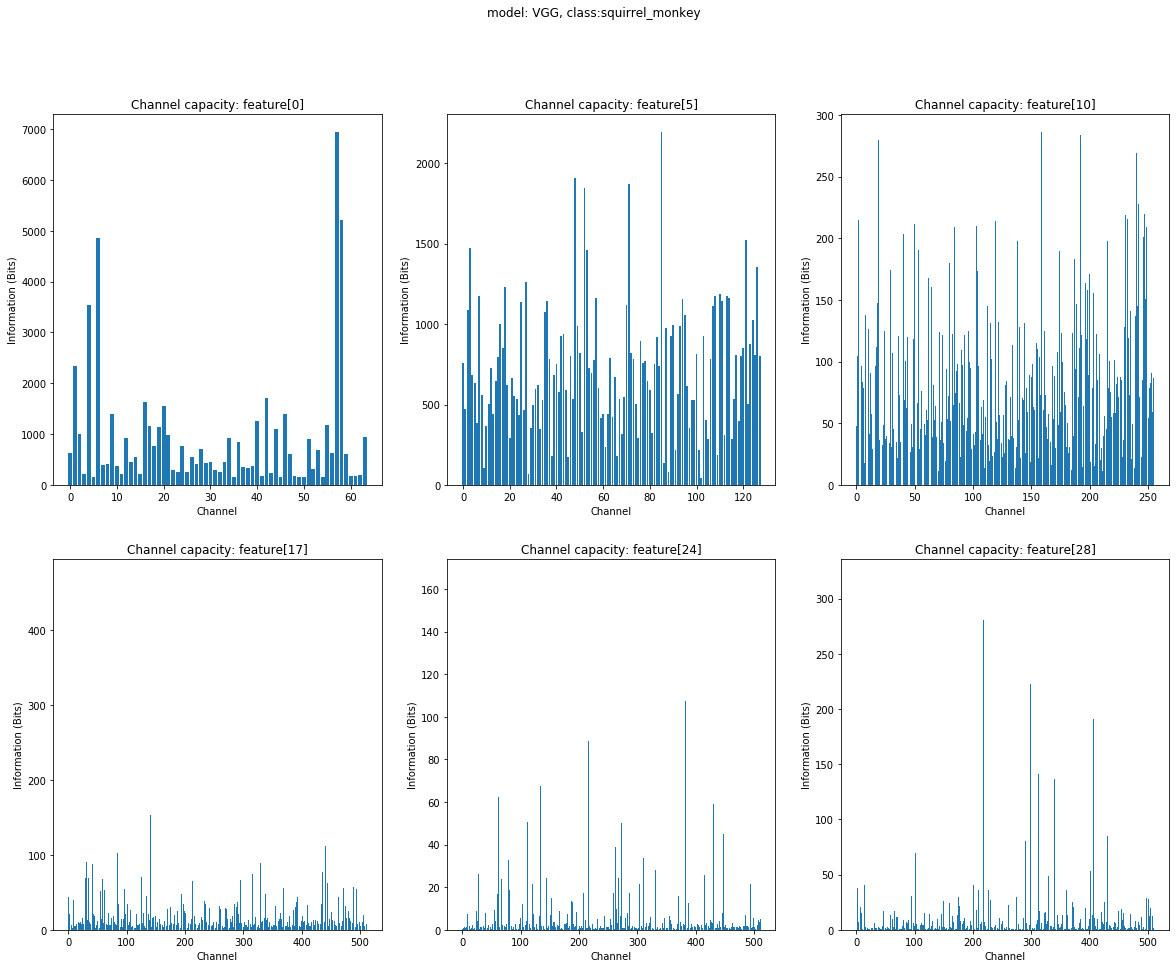

In [5]:
positions = [0, 5, 10, 17, 24, 28]
test_iba_channel(model, positions)

# Display heatmap for ResNet at different position

In [6]:
model = torchvision.models.resnet50(pretrained=True)
model.to(dev).eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Total information per layer:
relu: 123073.75
layer1: 47161.3203125
layer2: 50066.53125
layer3: 21720.572265625
layer4: 10048.05078125


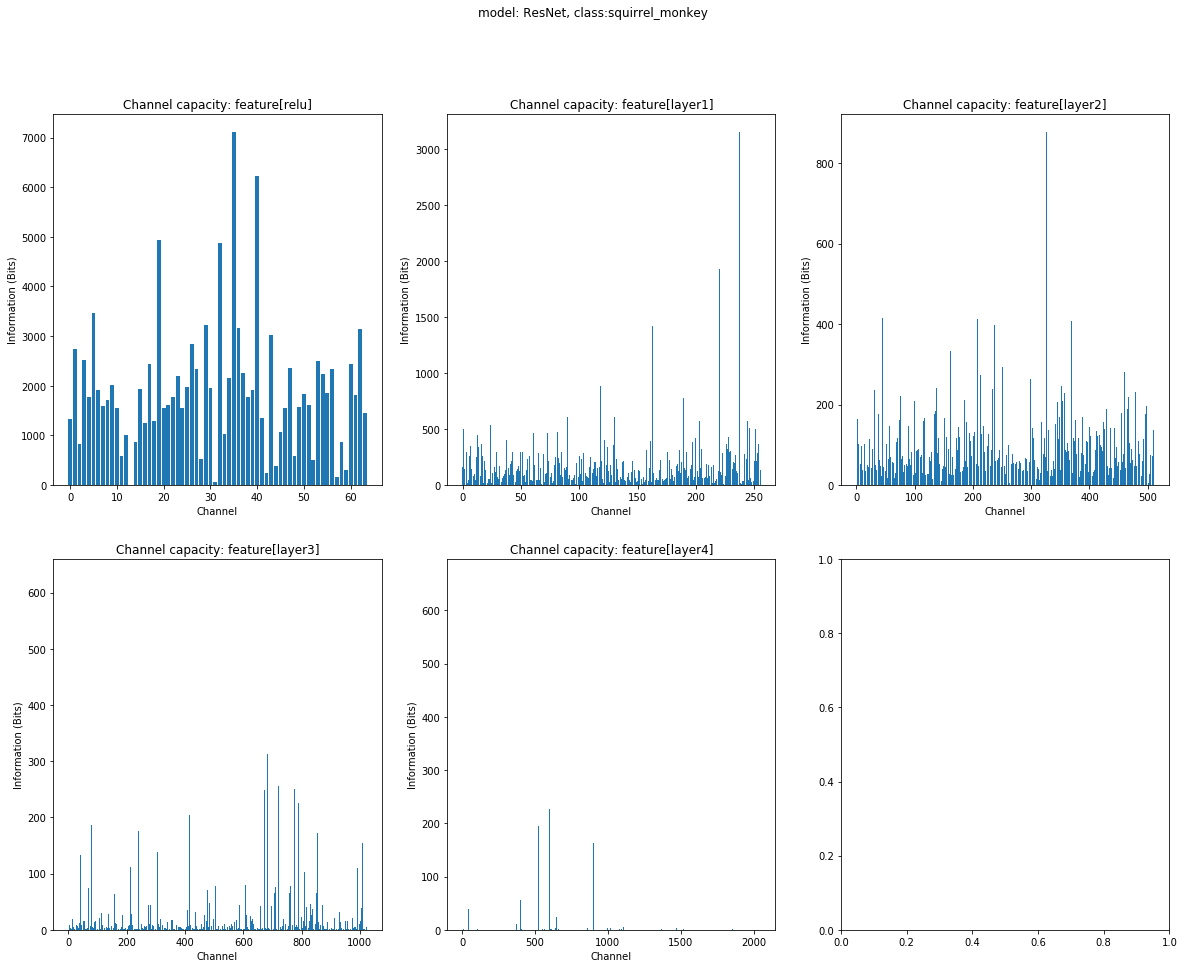

In [7]:
positions = ["relu", "layer1", "layer2", "layer3", "layer4"]
test_iba_channel(model, positions)

# Display heatmap for Inception at different position

In [8]:
model = torchvision.models.inception_v3(pretrained=True)
model.to(dev).eval()
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

Total information per layer:
Mixed_5b: 47121.953125
Mixed_6a: 24998.07421875
Mixed_6c: 16759.1328125
Mixed_6e: 21511.103515625
Mixed_7b: 15870.1806640625
Mixed_7c: 15358.20703125


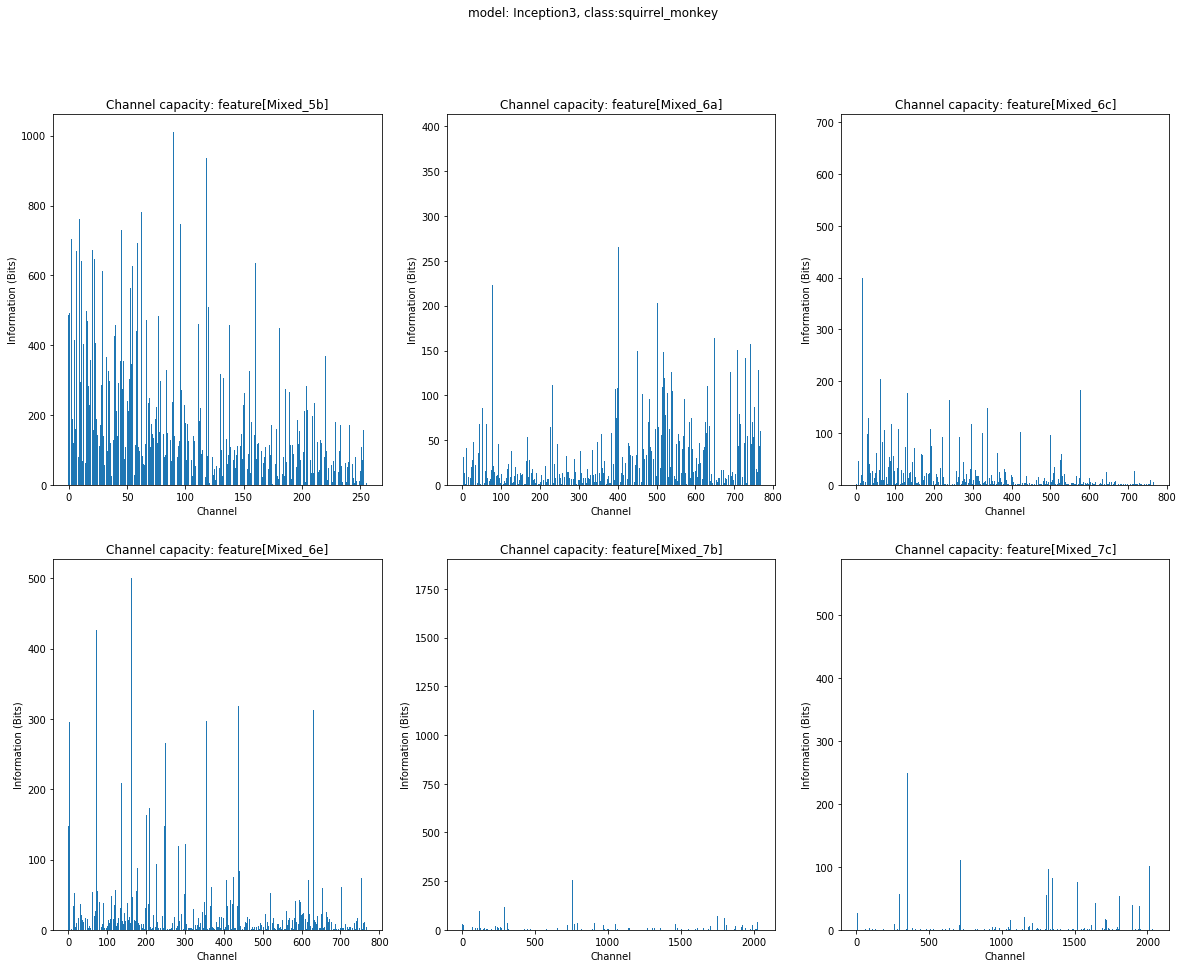

In [9]:
positions = ["Mixed_5b", "Mixed_6a", "Mixed_6c", "Mixed_6e", "Mixed_7b", "Mixed_7c"]
test_iba_channel(model, positions)

# Display mask for a single channel

In [12]:
def print_channel_mask(model, position):
    from copy import deepcopy
    
    # load the data
    if type(model) == torchvision.models.inception.Inception3:
        image_size = 299
    else:
        image_size = 224

    trainset = ImageFolder(
        os.path.join(imagenet_dir, 'train'),
        transform=Compose([
            CenterCrop(256), Resize(image_size), ToTensor(), 
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]))

    with open('imagenet_class_index.json') as f:
        idx2class = {int(k): v[1] for k, v in json.load(f).items()}

    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
    
    # load image
    fig, axes = plt.subplots(2, 3, figsize=(20,15))
    
    img = np.array(Image.open("./monkeys.jpg"))
    img = (img.transpose(2, 0, 1) / 255)
    target = 382  # 382: squirrel monkey

    # preprocess image
    img  = Compose([
        Resize(image_size), ToTensor(),  
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])(Image.open("./monkeys.jpg"))
        
    for ax in axes.flatten():
        if type(model) == torchvision.models.vgg.VGG:
            iba = IBA(model.features[position])
        else:
            iba = IBA(getattr(model, position))
        iba.reset_estimate()
        iba.estimate(model, trainloader, device=dev, n_samples=10, progbar=False)

        model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
        heatmap = iba.analyze(img[None].to(dev), model_loss_closure, mode="capacity") 
        channel = np.random.randint(low=0, high=heatmap.shape[0])
        channel_mask = heatmap[channel]
        vmax = heatmap.max()
        norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
        n = 256
        half_jet_rgba = plt.cm.seismic(np.linspace(0.5, 1, n))
        half_jet_rgba[:, -1] = np.linspace(0.2, 1, n)
        cmap = mpl.colors.ListedColormap(half_jet_rgba)
        hmap_jet = cmap(norm(saliency_map))
        if img is not None:
            hmap_jet[:, :, -1] = (max_alpha - min_alpha)*norm(saliency_map) + min_alpha
        ax.imshow(hmap_jet, alpha=max_alpha)
        cbar = mpl.colorbar.ColorbarBase(cax1, cmap=cmap, norm=norm)
        cbar.set_label(colorbar_label, fontsize=colorbar_fontsize)
        ax.imshow(channel_mask)
        if type(model) == torchvision.models.vgg.VGG:
            ax.set_title("Channel mask: feature[{}]".format(position))
        else:
            ax.set_title("Channel mask: {}".format(position))
#     layer_mask = heatmap.sum(0)
#     plt.imshow(layer_mask)
            
    fig.suptitle("model: {}, class:{}".format(type(model).__name__, idx2class[target]))
    plt.show()

[[0.00183428 0.00193902 0.00317385 0.00492627 0.00524091 0.00364685
  0.00254547 0.00218543 0.00205511 0.00158082 0.00137135 0.00147922
  0.00181055 0.00201688]
 [0.00376595 0.00260253 0.00389094 0.00494798 0.00377515 0.00290831
  0.00241928 0.00319475 0.00457938 0.0023136  0.00124636 0.00136941
  0.00254079 0.00265098]
 [0.01432929 0.00717396 0.00712993 0.00607395 0.00692002 0.00539088
  0.0023728  0.00194044 0.00535915 0.00450556 0.00232766 0.0014889
  0.00216148 0.00197311]
 [0.01668872 0.00406047 0.00318766 0.00289541 0.00163319 0.00173436
  0.00155464 0.00200467 0.00394795 0.00634577 0.00395766 0.00141924
  0.00120156 0.00122933]
 [0.01621345 0.00367316 0.00657748 0.00792285 0.00379656 0.00148473
  0.00183071 0.00210726 0.00191584 0.00173659 0.00147389 0.00112176
  0.00113306 0.00123152]
 [0.00581809 0.00228096 0.00221471 0.00319853 0.00187822 0.00135871
  0.00203602 0.00251864 0.00202411 0.00136202 0.0011086  0.00107562
  0.00116265 0.00115817]
 [0.00157497 0.00151882 0.00172232 

[[0.00208955 0.00204268 0.00226441 0.00287258 0.00255854 0.00180823
  0.00143558 0.00154763 0.00166191 0.00227563 0.00283006 0.00198373
  0.00159101 0.00127594]
 [0.00158895 0.00180031 0.00211724 0.00377257 0.0039013  0.00234447
  0.00168951 0.00181734 0.00159991 0.00194886 0.00221273 0.00175199
  0.00150382 0.00131752]
 [0.00145304 0.00153163 0.00212119 0.00481078 0.00415854 0.00252045
  0.00170473 0.0013569  0.00220426 0.00265163 0.00173565 0.00170989
  0.00182095 0.00209195]
 [0.00136309 0.00147239 0.002382   0.00407625 0.00295655 0.00179632
  0.00137745 0.0023409  0.00444167 0.00423916 0.00223977 0.00170886
  0.00199319 0.00343957]
 [0.00122456 0.00123785 0.0013385  0.00146981 0.00143348 0.0012912
  0.0014281  0.00198554 0.00188889 0.0016976  0.00170697 0.002336
  0.00223169 0.00243381]
 [0.00106556 0.0010911  0.00117997 0.00137861 0.00142161 0.00121028
  0.00119597 0.00130991 0.0014941  0.00180031 0.0022086  0.00257944
  0.00206525 0.00203662]
 [0.00148589 0.00191756 0.00134925 0.

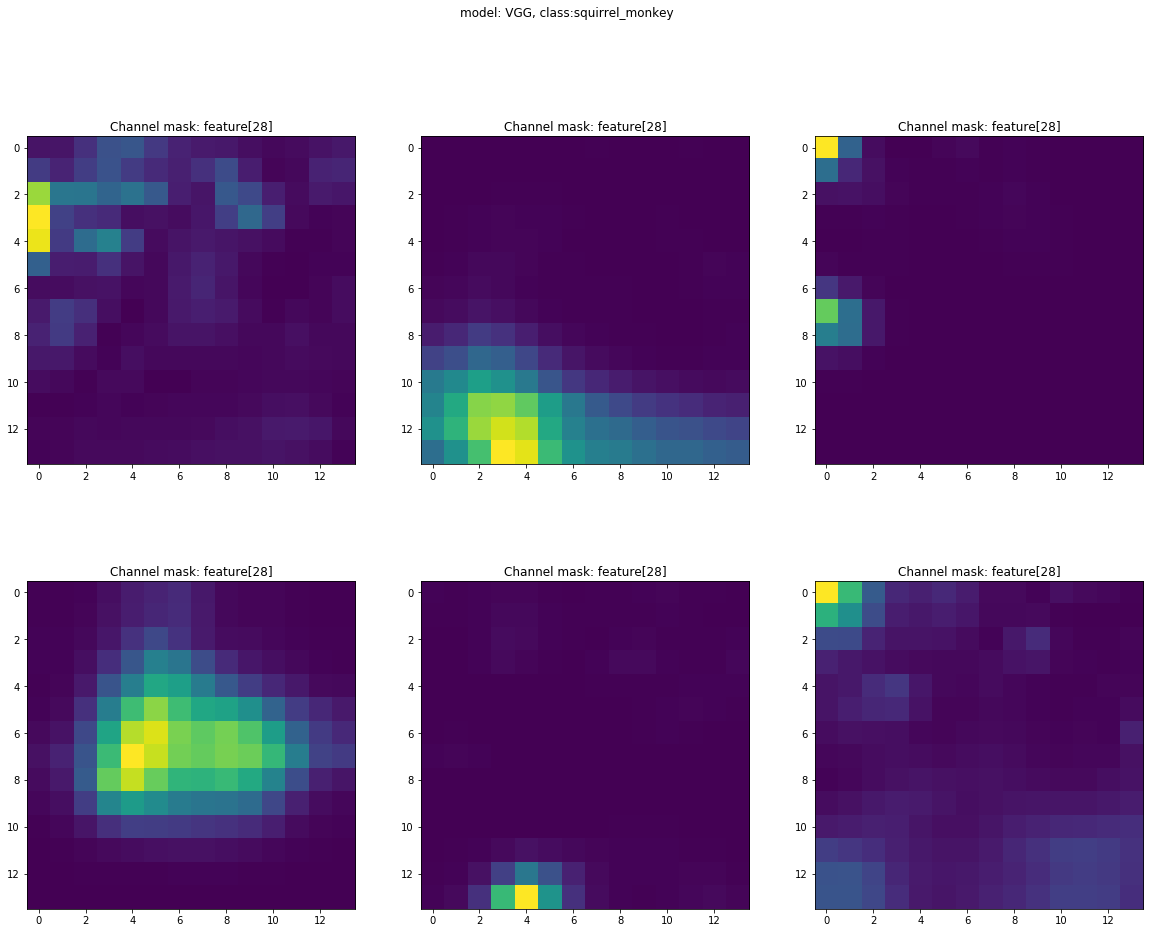

In [13]:
model = torchvision.models.vgg16(pretrained=True)
model.to(dev).eval()
# positions = [0, 5, 10, 17, 24, 28]
position = 28
print_channel_mask(model, position)